# Diabetes Food Recommender


Using Logistic Regression to classify whether a deabetic patient should choose More Often, Less Often, or In Moderation for a specific food item based on the nutrition inmformation in the dataset. A multinomial logistic regression is a generalized logistic regression model which generates a probability distribution over all classes, based on the logits or exponentiated log-odds calculated for each class (usually more than two). Also note that a multinomial logistic regression model is different from the one-vs-rest binary logistic regression. For one-vs-rest schema, we need to train an independent classifier for each class. For example, we need a More Often classifier to differentiate a food item between More Often and Not More Often (or, In Moderation and Less Often).

### Objective:

- Preprocess and generate training and testing datasets
- Train and fine-tune logistic regression models
- Interpret trained logistic regression models
- Evaluate trained logistic regression models

#### Step 1: Load and explore the dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
RANDOM_STATE = 123

In [3]:
df = pd.read_csv("food_items.csv")
print(df.head())

   Calories  Total Fat  Saturated Fat  Monounsaturated Fat  \
0     149.0          0            0.0                  0.0   
1     123.0          0            0.0                  0.0   
2     150.0          0            0.0                  0.0   
3     110.0          0            0.0                  0.0   
4     143.0          0            0.0                  0.0   

   Polyunsaturated Fat  Trans Fat  Cholesterol  Sodium  Total Carbohydrate  \
0                  0.0        0.0            0     9.0                 9.8   
1                  0.0        0.0            0     5.0                 6.6   
2                  0.0        0.0            0     4.0                11.4   
3                  0.0        0.0            0     6.0                 7.0   
4                  0.0        0.0            0     7.0                13.1   

   Dietary Fiber  Sugars  Sugar Alcohol  Protein  Vitamin A  Vitamin C  \
0            0.0     0.0              0      1.3          0          0   
1         

In [4]:
print(df.dtypes)

Calories               float64
Total Fat                int64
Saturated Fat          float64
Monounsaturated Fat    float64
Polyunsaturated Fat    float64
Trans Fat              float64
Cholesterol              int64
Sodium                 float64
Total Carbohydrate     float64
Dietary Fiber          float64
Sugars                 float64
Sugar Alcohol            int64
Protein                float64
Vitamin A                int64
Vitamin C                int64
Calcium                  int64
Iron                     int64
class                   object
dtype: object


In [7]:
print(df['class'].value_counts(normalize=True))

class
'In Moderation'    0.501433
'Less Often'       0.423906
'More Often'       0.074661
Name: proportion, dtype: float64


As we can see from the bar chart above, this dataset has three classes: In Moderation, Less Often, and More Often. The three labels are imbalanced. For diabetic patients, most food items are in the In Moderation and Less Often categories. This makes diabetes diet management very hard, so we could build a machine learning model to help patients choose their food

Now let us get the row entries with col 0 to -1 (16) since last column is "class", and obtain descriptive statistics

In [6]:
df.iloc[:,:-1].describe()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000
mean,133.861086,4.475264,1.450617,0.338069,0.254660,0.047459,8.857692,241.867142,18.232020,1.602971,6.645234,0.117949,4.661333,6.287632,6.741855,5.175264,5.235671
std,94.227650,5.386340,2.410318,1.345852,2.230586,0.321402,20.976530,272.284363,14.786316,3.363879,8.328465,1.121529,5.611143,18.374191,23.785100,8.779637,9.119459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,135.000000,17.000000,1.000000,3.000000,0.000000,3.000000,0.000000,0.000000,2.000000,2.000000
75%,180.000000,7.000000,2.000000,0.000000,0.000000,0.000000,10.000000,370.000000,27.000000,2.000000,11.000000,0.000000,7.000000,6.000000,2.000000,6.000000,8.000000
max,2210.000000,43.000000,22.000000,40.000000,235.000000,11.000000,450.000000,2431.000000,270.000000,305.000000,115.000000,31.000000,70.000000,622.000000,1000.000000,110.000000,170.000000


#### Step 2: Feature engineering

Now we should have some basic understanding about the food dataset. Next, let's process the raw dataset and construct input data X and label/output y for logistic regression model training.

In [10]:
# Split features and target
X_raw = df.drop(columns=['class'])
y_raw = df['class']

# Scale numeric feature to range [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_raw)

print(f"The range of feature inputs are within {X.min()} to {X.max()}")

# Encode target variable (class) 
le = LabelEncoder()
y = le.fit_transform(y_raw.values.ravel())

# The encoded target variable will only contain values 0=In Moderation, 1=Less Often, 2=More Often.
np.unique(y, return_counts=True)


The range of feature inputs are within 0.0 to 1.0


(array([0, 1, 2]), array([6649, 5621,  990]))

#### Step 3: Train logistic regression models

First, let's split the dataset into a training and a testing dataset. Training dataset will be used to train and (maybe) tune models, and testing dataset will be used to evaluate the models. Note we may also split the training dataset into train and validation sets where the validation dataset is only used to tune the model and to set the model parameters.

In [ ]:
# Use an 80/20 to split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (10608, 17), y_train: (10608,)
Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


#### Step 4: Define and Train three models

Now we have separated the training and testing datasets, let's start the model training.

We’ll loop over three configurations:

- **L2 (“ridge”)**: shrinks all coefficients but none go exactly zero.
- **L1 (“lasso”)**: can zero out coefficients, for feature selection.
- **Elastic-Net**: blend of L1+L2 (`l1_ratio=0.1` → 10% L1 + 90% L2).

All use `multi_class='multinomial'` and `max_iter=1000`.  
Note: **saga** solver is required for L1 and elasticnet; **lbfgs** can do L2.


In [19]:
# L2 penalty to shrink coefficients without removing any features from the model
l2_model = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Train the model with training input data X_train and lables y_train
l2_model.fit(X_train, y_train)
l2_preds = l2_model.predict(X_test)

c:\Users\able3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Now we will creat an evaluate the model for multiple time use with different model hyper parameters

In [22]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [23]:
# Evaluate the model with y_test, l2_preds
evaluate_metrics(y_test, l2_preds)

{'accuracy': 0.7748868778280543,
 'recall': array([0.87368421, 0.73220641, 0.35353535]),
 'precision': array([0.73035827, 0.83553299, 0.92105263]),
 'f1score': array([0.79561794, 0.78046468, 0.51094891])}

As we can see from the above evaluation results, the logistic regression model has relatively good performance on this multinomial classification task. The overall accuracy is around 0.77 and the f1score is around 0.8. Note that for recall, precision, and f1score, we output the values for each class to see how the model performs on an individual class. And, we can see from the results, the recall for class=2 (More often) is not very good. Next, let's try defining another logistic regression model with l1 penality this time, to see if our classification performance would be improved.

In [24]:
# L1 penalty to shrink coefficients without removing any features from the model
l1_model = LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Train the model with training input data X_train and lables y_train
l1_model.fit(X_train, y_train)
l1_preds = l1_model.predict(X_test)

c:\Users\able3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [25]:
evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.8092006033182504,
 'recall': array([0.85488722, 0.74377224, 0.87373737]),
 'precision': array([0.78848821, 0.83516484, 0.8277512 ]),
 'f1score': array([0.82034632, 0.78682353, 0.85012285])}

Now, we can see this logistic regression with l1 penalty has much better performance than l2. One possible reason is that l1 penalty may remove some correlated feature variables by shrinking their coefficents to zero. As such, the model is much simplified to avoid overfitting on the training data and better aligned with the logistic regression assumption that all features should be independent. Let us try a logistic regression with elastic-net penality.

In [27]:
en_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.1, 
    multi_class='multinomial',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Train the model with training input data X_train and lables y_train
en_model.fit(X_train, y_train)
en_preds = en_model.predict(X_test)

c:\Users\able3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [28]:
evaluate_metrics(y_test, en_preds)

{'accuracy': 0.7782805429864253,
 'recall': array([0.87218045, 0.73220641, 0.40909091]),
 'precision': array([0.73510773, 0.83553299, 0.91011236]),
 'f1score': array([0.79779917, 0.78046468, 0.56445993])}

Overall we can see that l1 wins at 0.81 vs. 0.78 for both l2 and Elastic_Net, means l1-penalized (Lasso) logistic regression is clearly the best performance here: highest overall accuracy, dtratically better at identifying the rare "More Ofter" class (both recall and F1). ls and Elastic_Net behave very similarly, both struggle to recal the minority class (only 35-40%).

#### Step 5: Confusion matrix

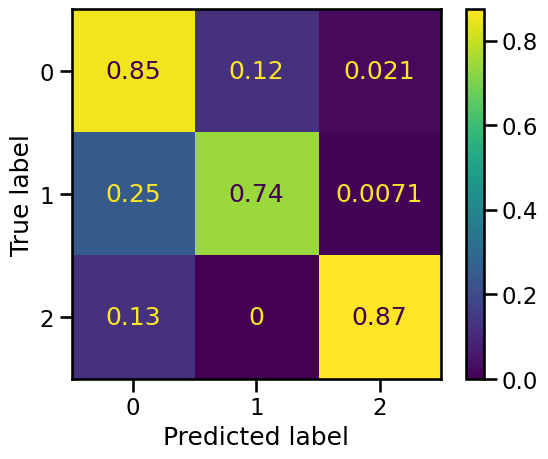

In [30]:
cf = confusion_matrix(y_test, l1_preds, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=l1_model.classes_)
disp.plot()
plt.show()

We can check the coefficients for logistic regression model using its coef_ attribute:

In [31]:
l1_model.coef_

array([[ 1.02260612e+01,  0.00000000e+00,  0.00000000e+00,
         5.28211590e+00,  0.00000000e+00, -3.70560617e+00,
         0.00000000e+00,  9.11923717e-01,  0.00000000e+00,
         2.26627496e+01,  0.00000000e+00,  0.00000000e+00,
         4.30564271e+00,  1.36942545e-01,  0.00000000e+00,
         1.83340368e+00, -2.06761520e-02],
       [ 0.00000000e+00,  4.20223530e+00,  2.46648466e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.94277520e+00,  0.00000000e+00,  1.32251480e+00,
        -6.79834695e+00,  1.51669845e+01,  3.46648083e+00,
         0.00000000e+00, -1.71144958e+00,  0.00000000e+00,
        -1.47866235e-01,  0.00000000e+00],
       [-1.11431018e+02, -2.91410454e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.59642876e+00, -4.13437893e+01,
         0.00000000e+00, -9.27079323e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

The coef_ is a coefficients list with three elements, one element is the actual coefficent for class 0, 1, 2. To better analyze the coefficients, let's use three utility methods to sort and visualize them.

In [32]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

Then, let's visualize the sorted coefficient for class 1, the Less Often class:

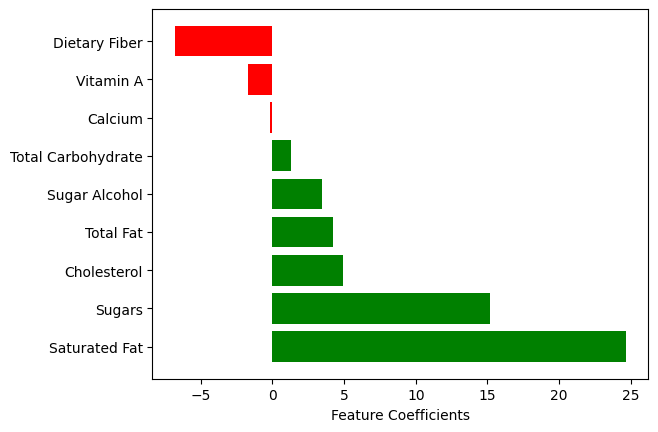

In [36]:
feature_cols = list(df.iloc[:, :-1].columns)
coef_dict = get_feature_coefs(l1_model, 1, feature_cols)
visualize_coefs(coef_dict)

As we can see, unhealthy nutrients such as Saturated Fat, Sugars, Cholesterol, Total Fat, etc., have high positive coefficients. Food items containing unhealthy nutrients will have higher coeficients and will be more likely to be categorized in the 'Less Often' class.

Next, let's see the coefficents for Class 2, More Often:

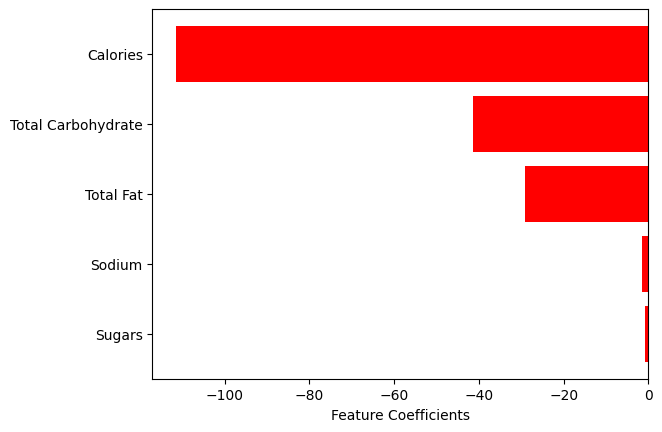

In [37]:
coef_dict = get_feature_coefs(l1_model, 2, feature_cols)
visualize_coefs(coef_dict)

Conversely, if a food item has a high amount of calories, total carbohydrates, and total fat, then it is unlikely to be categorized in the 'More Often' class.

#### Step 6: Hyperparameter Tuning with Cross-Validation

In [38]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# Rebuild an L1-penalized logistic model
base = LogisticRegression(
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Grid search (5-fold CV)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring='f1_weighted',   # optimize weighted F1
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV weighted F1:", grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\able3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params: {'C': 100, 'class_weight': None}
Best CV weighted F1: 0.815549269154201


c:\Users\able3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We’ve found that the L1-penalized logistic model performs best at C = 100 without class weighting, with a cross-validated weighted F1 of ≈ 0.816. The ConvergenceWarning tells us that even at max_iter=1000 the solver didn’t fully converge—so let’s clean that up, retrain on the full training set.



In [40]:
best_l1 = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=100,
    class_weight=None,
    multi_class='multinomial', 
    max_iter=5000,              
    tol=1e-4,                    
    random_state=RANDOM_STATE
)

best_l1.fit(X_train, y_train)
best_l1_preds = best_l1.predict(X_test)

c:\Users\able3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [41]:
evaluate_metrics(y_test, best_l1_preds)

{'accuracy': 0.8141025641025641,
 'recall': array([0.8556391, 0.75     , 0.8989899]),
 'precision': array([0.79469274, 0.83880597, 0.82790698]),
 'f1score': array([0.82404055, 0.79192109, 0.86198547])}

Above numbers show our tuned L1 model just jumped to ≈81.4% accuracy and solid per-class F1s (especially the minority “More Often” at ~0.862)

#### Step 7: Visualize the Confusion Matrix one more time

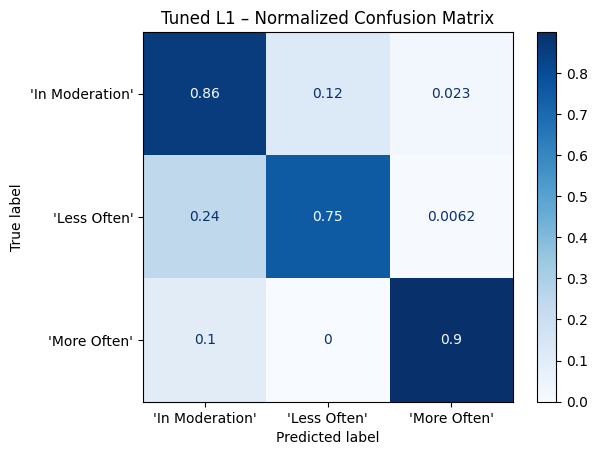

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_l1.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Tuned L1 – Normalized Confusion Matrix")
plt.show()

What it tells us:

- "In moderation class - 86% of true “In Moderation” items are correctly predicted, 12% are over-penalized as “Less Often,” and 2.3% are under-penalized as “More Often.”
- "In less often" - Only 75% of true “Less Often” are correctly flagged, 24% get mis-labeled as “In Moderation,” meaning the model sometimes under-penalizes these higher-risk foods.
- "In more often: - 90% correctly identified—excellent for the minority class, 10% slips through as “In Moderation,” but none are confused with “Less Often.”